In [1]:
import fdfi
print('FDFI version:', fdfi.__version__)

FDFI version: 0.0.2


# Confidence Intervals and Statistical Inference

This tutorial covers statistical inference with FDFI, including confidence intervals, hypothesis testing, and feature selection.

## What You'll Learn

1. Computing confidence intervals with `conf_int()`
2. One-sided vs two-sided tests
3. Variance floor for stable inference
4. Practical significance margins
5. Statistically-driven feature selection

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from fdfi.explainers import OTExplainer

np.random.seed(42)

## Setup

Create a model where we know the true feature importance:

In [3]:
n_features = 10
n_train = 500
n_test = 100

# True importance: features 0, 1, 2 are important; rest are noise
true_coefs = np.array([2.0, 1.5, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

def model(X):
    return X @ true_coefs

X_train = np.random.randn(n_train, n_features)
X_test = np.random.randn(n_test, n_features)

# Create explainer
explainer = OTExplainer(model, data=X_train, nsamples=100)
results = explainer(X_test)

print("True coefficients:", true_coefs)
print("Estimated importance:", results["phi_X"].round(3))

True coefficients: [2.  1.5 0.5 0.  0.  0.  0.  0.  0.  0. ]
Estimated importance: [3.641e+00 2.674e+00 2.270e-01 7.000e-03 1.200e-02 7.000e-03 4.000e-03
 1.000e-03 9.000e-03 1.500e-02]


## Basic Confidence Intervals

The `conf_int()` method computes pointwise confidence intervals:

In [4]:
# Two-sided 95% confidence intervals
ci = explainer.conf_int(alpha=0.05, alternative="two-sided")

print("Two-sided 95% Confidence Intervals:")
print("-" * 70)
print(f"{'Feature':>8} {'Estimate':>10} {'SE':>10} {'CI Lower':>10} {'CI Upper':>10} {'P-value':>10}")
print("-" * 70)
for i in range(n_features):
    sig = "*" if ci["pvalue"][i] < 0.05 else ""
    print(f"{i:>8} {ci['phi_hat'][i]:>10.4f} {ci['se'][i]:>10.4f} "
          f"{ci['ci_lower'][i]:>10.4f} {ci['ci_upper'][i]:>10.4f} {ci['pvalue'][i]:>10.4f} {sig}")

Two-sided 95% Confidence Intervals:
----------------------------------------------------------------------
 Feature   Estimate         SE   CI Lower   CI Upper    P-value
----------------------------------------------------------------------
       0     3.6412     0.5222     2.6177     4.6646     0.0000 *
       1     2.6736     0.3974     1.8947     3.4524     0.0000 *
       2     0.2268     0.0410     0.1465     0.3071     0.0776 
       3     0.0073     0.0230    -0.0378     0.0524     0.0000 *
       4     0.0116     0.0230    -0.0336     0.0567     0.0000 *
       5     0.0067     0.0230    -0.0384     0.0519     0.0000 *
       6     0.0037     0.0230    -0.0414     0.0488     0.0000 *
       7     0.0008     0.0230    -0.0443     0.0459     0.0000 *
       8     0.0090     0.0230    -0.0361     0.0542     0.0000 *
       9     0.0151     0.0230    -0.0300     0.0603     0.0000 *


## Visualize Confidence Intervals

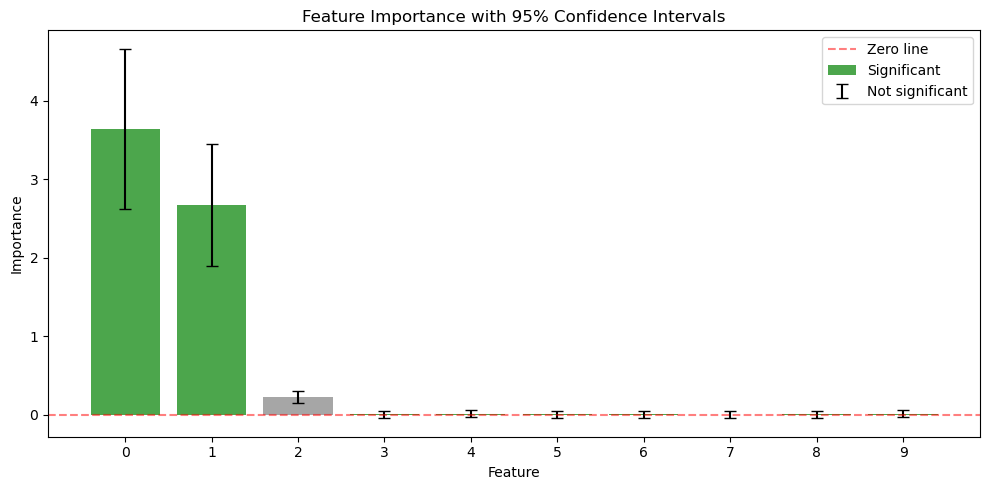

In [5]:
fig, ax = plt.subplots(figsize=(10, 5))

x = np.arange(n_features)
colors = ['green' if ci['reject_null'][i] else 'gray' for i in range(n_features)]

ax.bar(x, ci['phi_hat'], color=colors, alpha=0.7)
ax.errorbar(x, ci['phi_hat'], 
           yerr=[ci['phi_hat'] - ci['ci_lower'], ci['ci_upper'] - ci['phi_hat']],
           fmt='none', color='black', capsize=4)
ax.axhline(y=0, color='red', linestyle='--', alpha=0.5)
ax.set_xlabel('Feature')
ax.set_ylabel('Importance')
ax.set_title('Feature Importance with 95% Confidence Intervals')
ax.set_xticks(x)
ax.legend(['Zero line', 'Significant', 'Not significant'], loc='upper right')
plt.tight_layout()
plt.show()

## One-Sided Tests

For feature importance, we often care if a feature has **positive** importance. Use `alternative="greater"`:

In [6]:
# One-sided test: H0: phi <= 0 vs H1: phi > 0
ci_greater = explainer.conf_int(alpha=0.05, alternative="greater")

print("One-sided test (phi > 0):")
print("-" * 60)
print(f"{'Feature':>8} {'Estimate':>10} {'CI Lower':>10} {'P-value':>10} {'Significant':>12}")
print("-" * 60)
for i in range(n_features):
    sig = "Yes" if ci_greater["reject_null"][i] else "No"
    print(f"{i:>8} {ci_greater['phi_hat'][i]:>10.4f} "
          f"{ci_greater['ci_lower'][i]:>10.4f} {ci_greater['pvalue'][i]:>10.4f} {sig:>12}")

One-sided test (phi > 0):
------------------------------------------------------------
 Feature   Estimate   CI Lower    P-value  Significant
------------------------------------------------------------
       0     3.6412     2.7822     0.0000          Yes
       1     2.6736     2.0199     0.0000          Yes
       2     0.2268     0.1594     0.0388          Yes
       3     0.0073    -0.0306     1.0000           No
       4     0.0116    -0.0263     1.0000           No
       5     0.0067    -0.0311     1.0000           No
       6     0.0037    -0.0342     1.0000           No
       7     0.0008    -0.0370     1.0000           No
       8     0.0090    -0.0289     1.0000           No
       9     0.0151    -0.0228     1.0000           No


## Variance Floor

When some features have very small variance in their importance estimates, confidence intervals can become too narrow. The **variance floor** adds a minimum standard error.

Two methods are available:
- `fixed`: Use a constant floor value
- `mixture`: Fit a two-component mixture to estimate the floor

In [7]:
# Without variance floor
ci_no_floor = explainer.conf_int(alpha=0.05, var_floor_c=0)

# With fixed variance floor
ci_fixed = explainer.conf_int(alpha=0.05, var_floor_method="fixed", var_floor_c=0.1)

# With mixture-based floor
ci_mixture = explainer.conf_int(alpha=0.05, var_floor_method="mixture", var_floor_quantile=0.95)

print("Standard errors comparison:")
print("-" * 55)
print(f"{'Feature':>8} {'No Floor':>12} {'Fixed':>12} {'Mixture':>12}")
print("-" * 55)
for i in range(n_features):
    print(f"{i:>8} {ci_no_floor['se'][i]:>12.4f} {ci_fixed['se'][i]:>12.4f} {ci_mixture['se'][i]:>12.4f}")

Standard errors comparison:
-------------------------------------------------------
 Feature     No Floor        Fixed      Mixture
-------------------------------------------------------
       0       0.5222       0.5218       0.5222
       1       0.3974       0.3968       0.3974
       2       0.0410       0.0353       0.0410
       3       0.0230       0.0100       0.0230
       4       0.0230       0.0101       0.0230
       5       0.0230       0.0100       0.0230
       6       0.0230       0.0100       0.0230
       7       0.0230       0.0100       0.0230
       8       0.0230       0.0100       0.0230
       9       0.0230       0.0101       0.0230


## Practical Significance Margin

Instead of testing $H_0: \phi = 0$, you can test against a **practical threshold** $\delta$:

$$H_0: \phi \leq \delta \quad \text{vs} \quad H_1: \phi > \delta$$

This identifies features that are not just statistically different from zero, but also practically meaningful.

In [8]:
# Test with practical margin of 0.5
margin = 0.5
ci_margin = explainer.conf_int(
    alpha=0.05, 
    alternative="greater",
    margin=margin
)

print(f"Testing H0: phi <= {margin}")
print("-" * 50)
print(f"{'Feature':>8} {'Estimate':>10} {'P-value':>10} {'Significant':>12}")
print("-" * 50)
for i in range(n_features):
    sig = "Yes" if ci_margin["reject_null"][i] else "No"
    print(f"{i:>8} {ci_margin['phi_hat'][i]:>10.4f} {ci_margin['pvalue'][i]:>10.4f} {sig:>12}")

Testing H0: phi <= 0.5
--------------------------------------------------
 Feature   Estimate    P-value  Significant
--------------------------------------------------
       0     3.6412     0.0000          Yes
       1     2.6736     0.0000          Yes
       2     0.2268     0.0388          Yes
       3     0.0073     1.0000           No
       4     0.0116     1.0000           No
       5     0.0067     1.0000           No
       6     0.0037     1.0000           No
       7     0.0008     1.0000           No
       8     0.0090     1.0000           No
       9     0.0151     1.0000           No


## Automatic Margin via Mixture Model

Use `margin_method="mixture"` to automatically estimate a practical margin:

In [9]:
ci_auto_margin = explainer.conf_int(
    alpha=0.05,
    alternative="greater",
    margin_method="mixture",
    margin_quantile=0.95,
)

print(f"Automatically selected margin: {ci_auto_margin['margin']:.4f}")
print(f"Significant features: {np.where(ci_auto_margin['reject_null'])[0]}")

Automatically selected margin: 0.1545
Significant features: [0 1 2]


## Feature Selection with Statistical Guarantees

Use the confidence intervals to select features with controlled false discovery:

In [10]:
def statistical_feature_selection(explainer, X_test, alpha=0.05, margin=0.0):
    """Select features with statistical significance."""
    # Compute importance
    results = explainer(X_test)
    
    # Get confidence intervals
    ci = explainer.conf_int(
        alpha=alpha,
        alternative="greater",
        margin=margin,
        var_floor_method="mixture",
    )
    
    # Select significant features
    selected = np.where(ci["reject_null"])[0]
    
    # Sort by importance
    sorted_idx = np.argsort(ci["phi_hat"][selected])[::-1]
    
    return selected[sorted_idx], ci

# Run feature selection
selected_features, ci_result = statistical_feature_selection(
    explainer, X_test, alpha=0.05, margin=0.0
)

print("Selected Features (sorted by importance):")
print("-" * 40)
for i, feat in enumerate(selected_features):
    print(f"  {i+1}. Feature {feat} (importance = {ci_result['phi_hat'][feat]:.4f})")

print(f"\nTrue important features: 0, 1, 2")
print(f"Correctly identified: {set(selected_features) & {0, 1, 2}}")

Selected Features (sorted by importance):
----------------------------------------
  1. Feature 0 (importance = 3.6412)
  2. Feature 1 (importance = 2.6736)
  3. Feature 2 (importance = 0.2268)

True important features: 0, 1, 2
Correctly identified: {0, 1, 2}


## The `summary()` Method

For a quick formatted view, use the built-in `summary()` method:

In [11]:
# Print formatted summary
explainer.summary(
    alpha=0.05,
    alternative="greater",
    var_floor_method="mixture",
)

Feature Importance Results
Method: OTExplainer
Number of features: 10
Significance level: 0.05
Alternative: greater
Practical margin: 0.1545
------------------------------------------------------------------------------
 Feature   Estimate    Std Err   CI Lower   CI Upper    P-value   Sig
------------------------------------------------------------------------------
       0     3.6412     0.5222     2.7822        inf     0.0000   ***
       1     2.6736     0.3974     2.0199        inf     0.0000   ***
       2     0.2268     0.0410     0.1594        inf     0.0388    **
       3     0.0073     0.0230    -0.0306        inf     1.0000      
       4     0.0116     0.0230    -0.0263        inf     1.0000      
       5     0.0067     0.0230    -0.0311        inf     1.0000      
       6     0.0037     0.0230    -0.0342        inf     1.0000      
       7     0.0008     0.0230    -0.0370        inf     1.0000      
       8     0.0090     0.0230    -0.0289        inf     1.0000      
 

"==============================================================================\nFeature Importance Results\n==============================================================================\nMethod: OTExplainer\nNumber of features: 10\nSignificance level: 0.05\nAlternative: greater\nPractical margin: 0.1545\n------------------------------------------------------------------------------\n Feature   Estimate    Std Err   CI Lower   CI Upper    P-value   Sig\n------------------------------------------------------------------------------\n       0     3.6412     0.5222     2.7822        inf     0.0000   ***\n       1     2.6736     0.3974     2.0199        inf     0.0000   ***\n       2     0.2268     0.0410     0.1594        inf     0.0388    **\n       3     0.0073     0.0230    -0.0306        inf     1.0000      \n       4     0.0116     0.0230    -0.0263        inf     1.0000      \n       5     0.0067     0.0230    -0.0311        inf     1.0000      \n       6     0.0037     0.0230    -

## Summary

Key takeaways:

1. `conf_int()` provides confidence intervals and p-values for feature importance
2. Use `alternative="greater"` for one-sided tests of positive importance
3. Variance floor (`var_floor_method`) stabilizes inference for small effects
4. Practical margin (`margin`) tests against meaningful thresholds
5. Use `summary()` for quick formatted output